In [1]:
# Launch 7 parallel processes and load module in all
addprocs(7)
import QuantumBayesian
@everywhere using QuantumBayesian

using PyPlot

# One Qubit Stochastic Monitoring Test

**Justin Dressel**, Jan 4, 2016 <br />
*Institute for Quantum Studies, Chapman University*

Using a simple qubit Rabi oscillation problem, test whether the Quantum Bayesian update code for Julia produce sensible results for the simplest quantum problem of monitoring the observable of a single qubit.

## Problem Specification

Consider a qubit orbiting in the x-z plane of the Bloch sphere with unit period, with continuous monitoring of the z and/or y observables.

In [2]:
# Ensure qubit and Bloch coordinate functions are defined on all processes for parallelization
@everywhere q = qubit()
@everywhere x(ρ) = real(expect(ρ, q("x")));
@everywhere y(ρ) = real(expect(ρ, q("y")));
@everywhere z(ρ) = real(expect(ρ, q("z")));

In [3]:
@everywhere Ω  = 2*π;        # Rabi frequency, unit period
τ = 3.0;         # Measurement collapse timescale (given quantum-limited efficiency)
Γ = 1/(2*τ);     # Measurement dephasing rate
T = (0.0, 3*τ);  # Time duration of simulation;

# Hamiltonian: oscillations in x-z plane
H = (Ω/2)*q("y");

# Initial ground state
ρ0 = ground(q);

Below is convenience code for plotting purposes -- it is safe to skip to the next section.

In [4]:
function plot_solution(sol; plot_title="Monitored Rabi Oscillation", readout=false, ymeas=false, stds=[])
    # Plot Bloch components vs. time
    figure(1)
    ax = gca()
    ax[:set_ylim]([-1.1,1.1])
    hold(true)
    plot(sol[1].t, sol[1], label=L"$x$", color="r")
    plot(sol[2].t, sol[2], label=L"$y$", color="g")
    plot(sol[3].t, sol[3], label=L"$z$", color="b")
    if length(stds) > 0
        fill_between(sol[1].t, sol[1]-stds[1], sol[1]+stds[1], color="r", alpha=0.2, antialiased=true)
        fill_between(sol[2].t, sol[2]-stds[2], sol[2]+stds[2], color="g", alpha=0.2, antialiased=true)
        fill_between(sol[3].t, sol[3]-stds[3], sol[3]+stds[3], color="b", alpha=0.2, antialiased=true)
    end
    xlabel(L"$t\,\nu$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    hold(false)
    show()
    if readout
        figure(2)
        hold(true)
        plot(sol[4].t, sol[4], label=L"$r_z$", color="b")
        ymeas && plot(sol[5].t, sol[5], label=L"$r_y$", color="g")
        if length(stds) > 0
            fill_between(sol[4].t, sol[4]-stds[4], sol[4]+stds[4], color="b", alpha=0.2, antialiased=true)
            ymeas && fill_between(sol[5].t, sol[5]-stds[5], sol[5]+stds[5], color="g", alpha=0.2, antialiased=true)
        end
        xlabel(L"$t\,\nu$")
        ylabel("Stochastic Readout")
        title(plot_title*" Readout")
        legend()
        hold(false)
        show()
    end
end;

## Reference Lindblad Dynamics

First we benchmark pure Lindblad dephasing, to get a reference for the average dynamics and calibrate a reference speed.

Note that this Lindblad simulation corresponds to the master equation ($\hbar=1$):
$$ \dot{\rho} = -i[H,\,\rho] + \frac{\Gamma}{2}\left[\sigma_z\,\rho\,\sigma_z^\dagger - \frac{\{\sigma_z^\dagger\sigma_z,\, \rho\}}{2}\right] $$
with a similar dissipation term for $\sigma_y$ if both axes have dephasing.

In [5]:
# Measurement dephasing
DMz = sqrt(Γ/2)*q("z");
DMy = sqrt(Γ/2)*q("y");
@everywhere DM(t) = cos(2*Ω*t).*DMz + sin(2*Ω*t).*DMy;

# Deterministic averaged evolution (Lindblad equation)
function ensemble_average(; Δt=1/10^2, ymeas=false, tmeas=false, verbose=true)
    # Jump/no-jump Lindblad simulation
    inc = lind(Δt, H, clist=[DMz])
    ymeas && (inc = lind(Δt, H, clist=[DMz, DMy]))
    tmeas && (inc = lind(Δt, H, flist=[DM]))
    # Keep all simulated points
    trajectory(inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose)
end;

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.02046221 s, Steps per second: 43934.648310226505


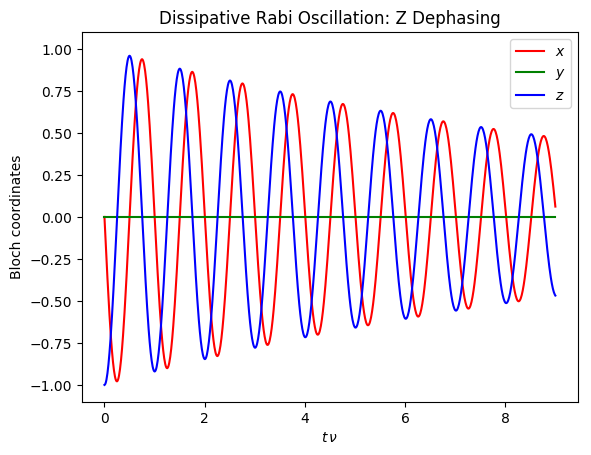

  0.292215 seconds (302.63 k allocations: 22.314 MiB, 2.29% gc time)


In [6]:
sol = ensemble_average(verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_average()
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Z Dephasing")

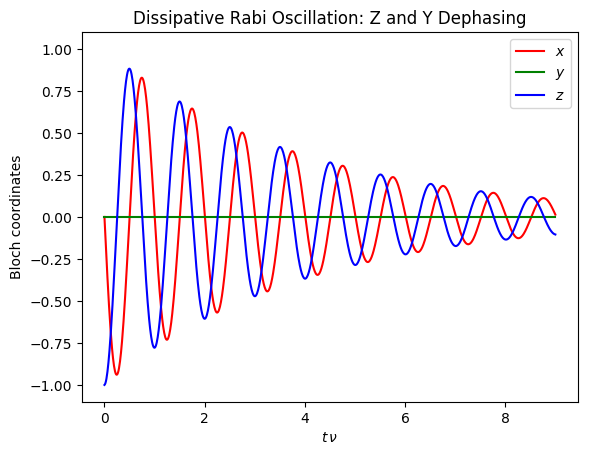

  0.034362 seconds (249.73 k allocations: 20.875 MiB, 23.78% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.033549001 s, Steps per second: 26796.62503214328


In [7]:
sol = ensemble_average(ymeas=true, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_average(ymeas=true)
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Z and Y Dephasing")

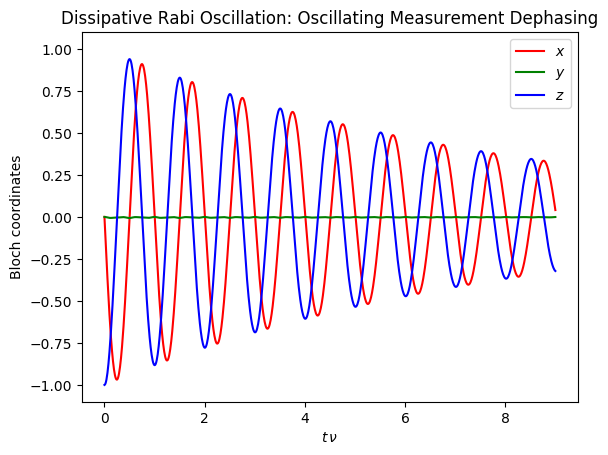

  0.050627 seconds (533.80 k allocations: 35.524 MiB, 15.38% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.049992326 s, Steps per second: 17982.75999400388


In [8]:
sol = ensemble_average(tmeas=true, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_average(tmeas=true)
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Oscillating Measurement Dephasing")

## Stochastic Dynamics Tests

Now we examine single trajectories and ensembles of trajectories carefully, to make sure they agree with the ensemble-averaged Lindblad dynamics.

Note that this simulation corresponds to the stochastic master equation:
$$ d\rho = -i[H,\,\rho]dt + \frac{\Gamma}{2}\left[\sigma_z\,\rho\,\sigma_z^\dagger - \frac{\{\sigma_z^\dagger\sigma_z,\, \rho\}}{2}\right]dt + \sqrt{\frac{\eta\,\Gamma}{2}}\left[\sigma_z\,e^{-i\phi}\,\rho + \rho\,\sigma_z^\dagger\,e^{i\phi} - \langle\sigma_z\,e^{-i\phi} + \sigma_z^\dagger\,e^{i\phi}\rangle\,\rho\right]dW $$

This can be rewritten in an elegant and more useful way for simulation using the collapse time $\tau = 1/(2\,\Gamma\,\eta)$ by defining the collapse operator
$$ A \equiv \sigma_z\,e^{-i\phi} \equiv A_r - i\, A_i $$
whose real (Hermitian) part corresponds to the measured observable, and whose imaginary (anti-Hermitian) part corresponds to the phase back-action. 

This collapse operator produces a single Kraus operator that governs the total back-action from the collected signal:
$$ M_r = \left(\frac{dt}{2\pi\tau}\right)^{1/4}\,\exp\left[ -i\,\frac{dt\,A_i}{2\tau}\, -\, \frac{dt\,(r-A_r)^2}{4\tau} \right] \propto \exp\left[\frac{dt\,A}{2\tau} - \frac{dt\,A_r^2}{4\tau}\right]$$

The signal $r$ is sampled from the probability distribution $P(r\,|\,\rho) = \text{Tr}[\rho\,M_r^\dagger M_r]$. It is easy to show that this results in the approximate moving-mean white-noise relation : 
$$r\,dt = \langle A_r \rangle\,dt + \sqrt{\tau}\,dW$$

In addition to this back-action, there is residual Lindblad dephasing that occurs at the modified rate:
$$ \gamma = \Gamma - \frac{1}{2\tau} = \frac{1-\eta}{2\,\tau\,\eta} $$

Such residual dephasing can be easily modeled separately using the jump/no-jump unraveling of the Lindblad equation:
$$ \rho(t+dt) = \frac{\gamma\,dt}{2}\,\sigma_z\,\rho(t)\,\sigma_z^\dagger + \sqrt{1 - \frac{\gamma\,dt}{2}\sigma_z^\dagger\sigma_z}\,\rho(t)\,\sqrt{1 - \frac{\gamma\,dt}{2}\sigma_z^\dagger\sigma_z} $$

This complete unraveling into exact discrete-step Kraus operators has the enormous benefit of being a valid completely positive map that preserves the properties of the state. Other methods for integrating the stochastic master equation do not converge in precision easily, comparatively.

In [9]:
function ensemble_realization(; Δt=1/10^2, η=1.0, n=1, ymeas=false, tmeas=false, ϕ=0.0, verbose=true)
    # Monitoring with tunable quantum efficiency
    inc = meas(Δt, H, mclist=[(exp(-im*ϕ).*q("z"), τ/η, η)])
    ymeas && (inc = meas(Δt, H, mclist=[(exp(-im*ϕ).*q("z"), τ/η, η), (exp(-im*ϕ).*q("y"), τ/η, η)]))
    tmeas && (inc = meas(Δt, H, mflist=[(t -> cos(2*Ω*t).*exp(-im*ϕ).*q("z") + sin(2*Ω*t).*exp(-im*ϕ).*q("y"), τ/η, η)]))
    # Choose one trajectory or an ensemble, accordingly
    if n==1
        trajectory(inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose, readout=true)
    else
        ensemble(n, inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose, readout=true)
    end
end;

### Single Trajectory Examples

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1


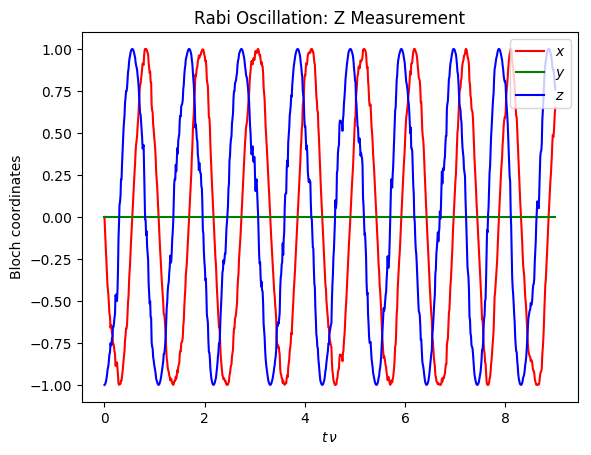

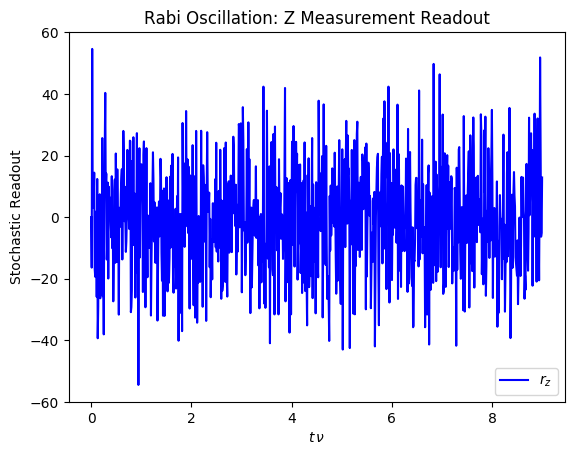

  0.027372 seconds (205.72 k allocations: 14.884 MiB, 22.50% gc time)


INFO: Time elapsed: 0.021159656 s, Steps per second: 42486.51301325504


In [10]:
sol = ensemble_realization(verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization()
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Z Measurement")

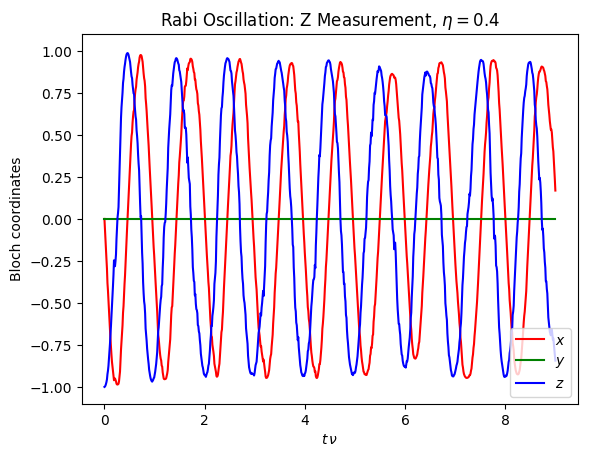

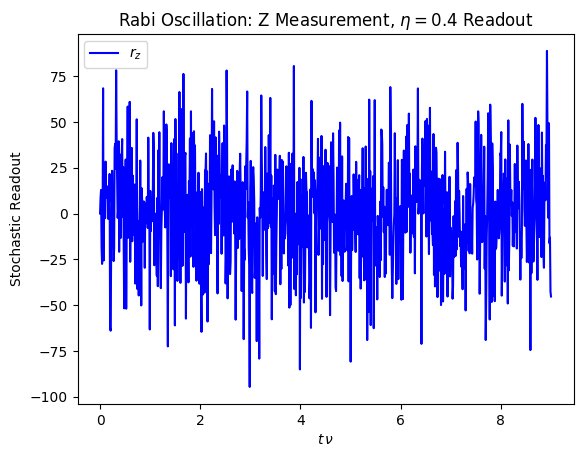

  0.040781 seconds (309.02 k allocations: 25.245 MiB, 13.26% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.039926451 s, Steps per second: 22516.401470293466


In [11]:
sol = ensemble_realization(η=0.4,verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Z Measurement, $\eta=0.4$")

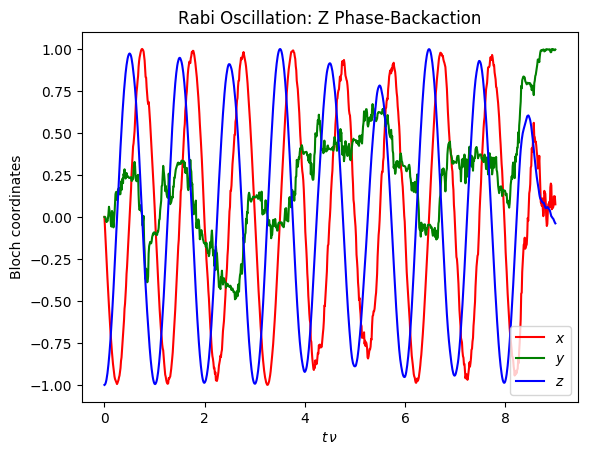

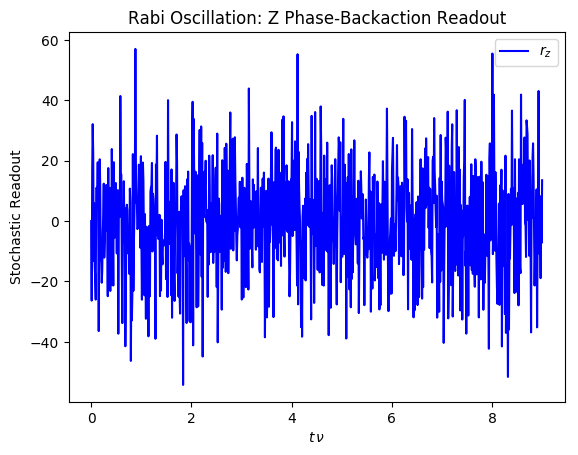

  0.028115 seconds (202.08 k allocations: 13.853 MiB, 26.44% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.027351894 s, Steps per second: 32867.9249780655


In [12]:
sol = ensemble_realization(ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ϕ=π/2)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Z Phase-Backaction")

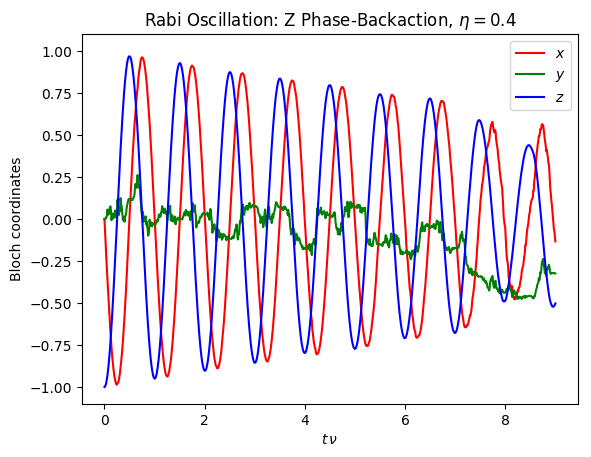

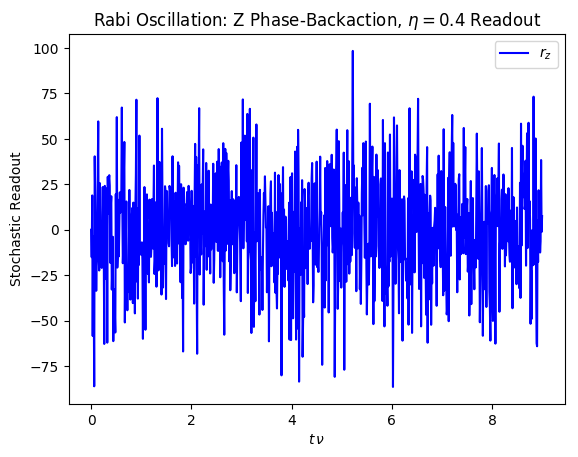

  0.040604 seconds (309.07 k allocations: 24.328 MiB, 12.59% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.039709491 s, Steps per second: 22639.423910016878


In [13]:
sol = ensemble_realization(ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Z Phase-Backaction, $\eta=0.4$")

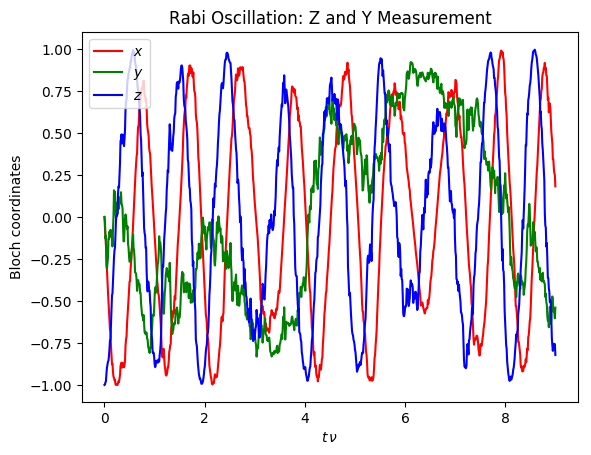

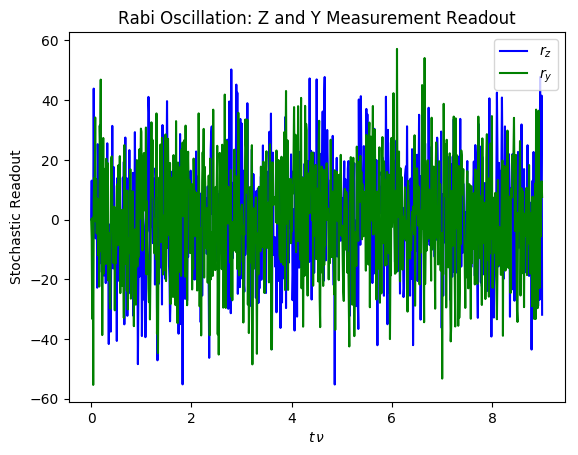

  0.030190 seconds (279.95 k allocations: 22.173 MiB, 14.94% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.02935613 s, Steps per second: 30623.927608986607


In [14]:
sol = ensemble_realization(ymeas=true, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true)
plot_solution(sol, readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Measurement")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2


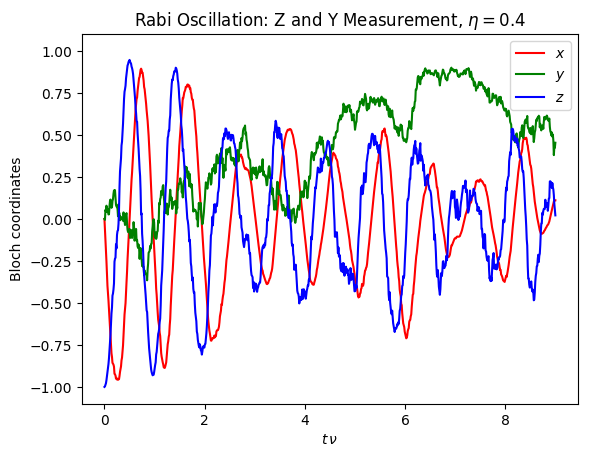

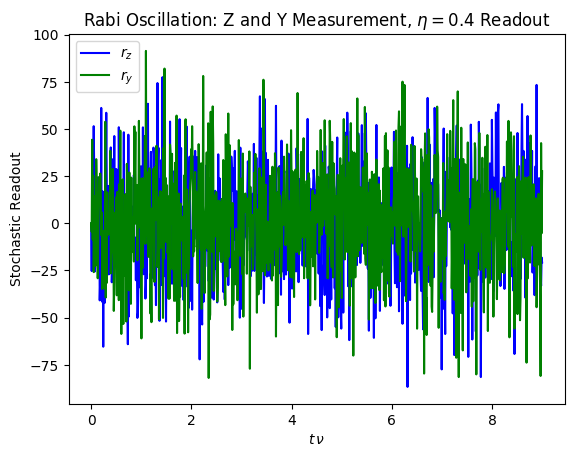

  0.072759 seconds (432.88 k allocations: 36.904 MiB, 6.58% gc time)


INFO: Time elapsed: 0.071910907 s, Steps per second: 12501.580601674235


In [15]:
sol = ensemble_realization(ymeas=true, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, η=0.4)
plot_solution(sol, readout=true, ymeas=true, plot_title=L"Rabi Oscillation: Z and Y Measurement, $\eta=0.4$")

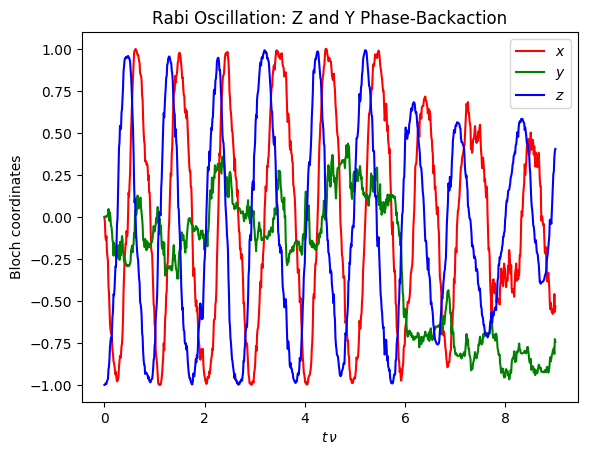

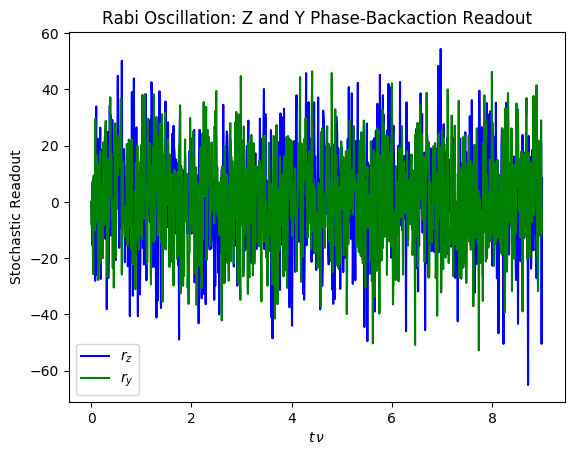

  0.034832 seconds (282.01 k allocations: 20.625 MiB, 12.32% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.033967941 s, Steps per second: 26466.13169753209


In [16]:
sol = ensemble_realization(ymeas=true, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, ϕ=π/2)
plot_solution(sol, readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Phase-Backaction")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2


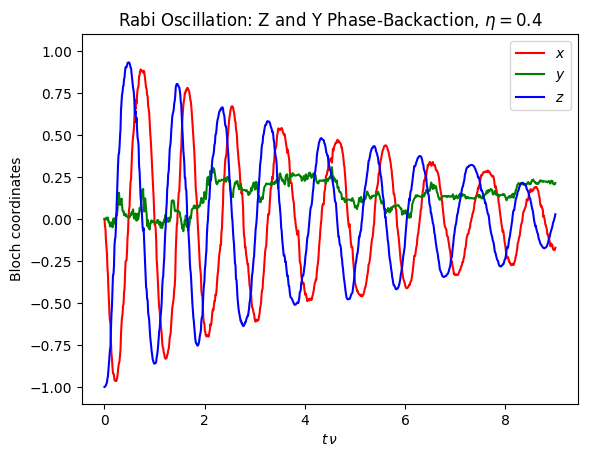

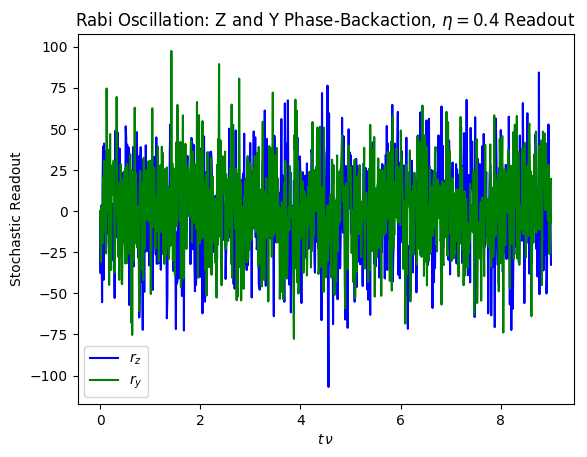

  0.055913 seconds (433.13 k allocations: 35.096 MiB, 20.10% gc time)


INFO: Time elapsed: 0.05497288 s, Steps per second: 16353.518316668145


In [17]:
sol = ensemble_realization(ymeas=true, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, ymeas=true, plot_title=L"Rabi Oscillation: Z and Y Phase-Backaction, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1


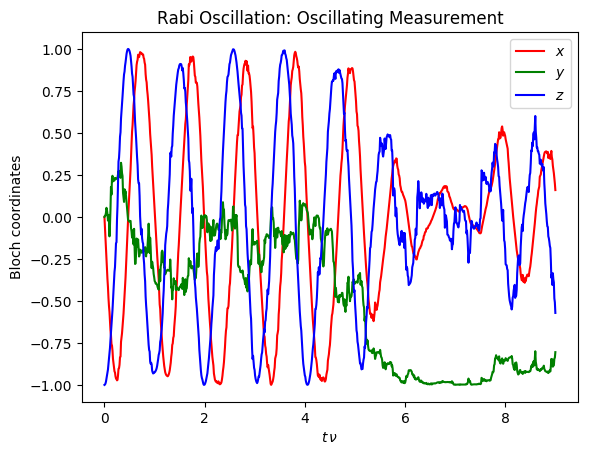

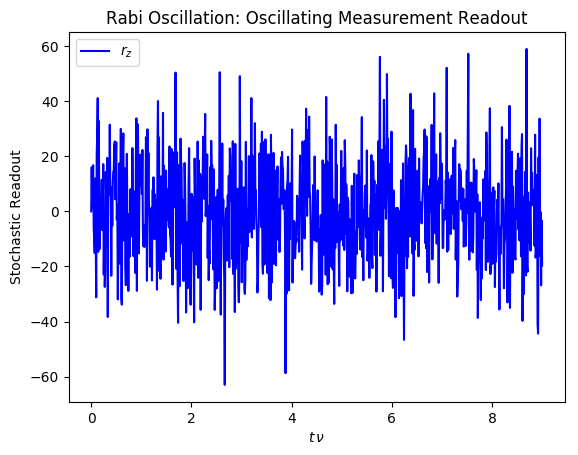

  0.097522 seconds (621.16 k allocations: 32.633 MiB, 10.59% gc time)


INFO: Time elapsed: 0.09673575 s, Steps per second: 9293.358453312245


In [18]:
sol = ensemble_realization(tmeas=true, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Oscillating Measurement")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.184905103 s, Steps per second: 4861.953431323093


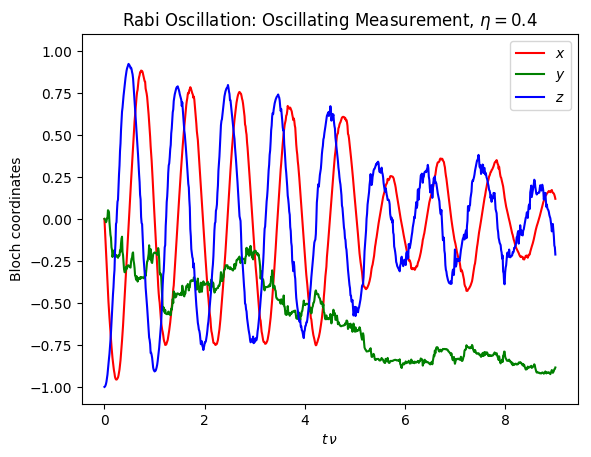

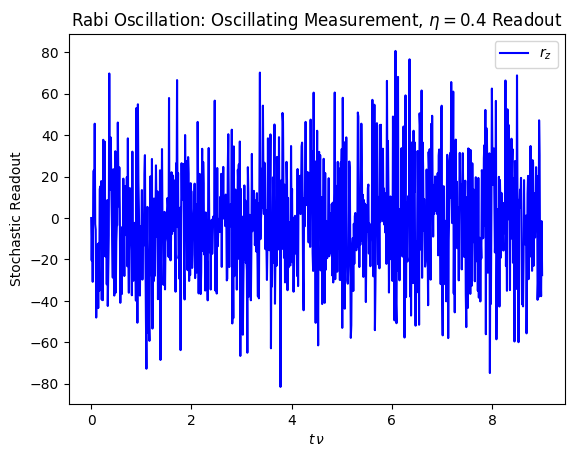

  0.185749 seconds (1.43 M allocations: 75.031 MiB, 7.16% gc time)


In [19]:
sol = ensemble_realization(tmeas=true, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Oscillating Measurement, $\eta=0.4$")

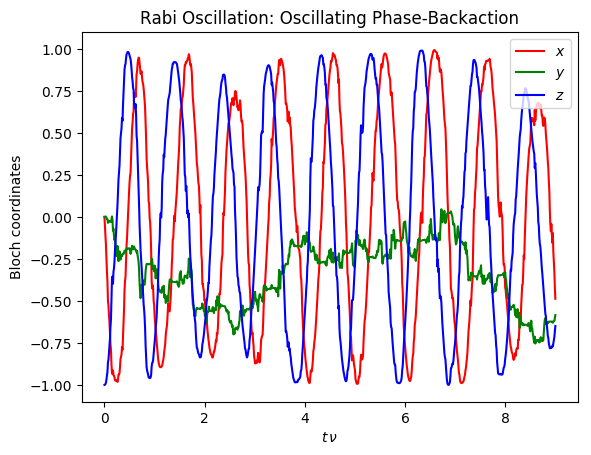

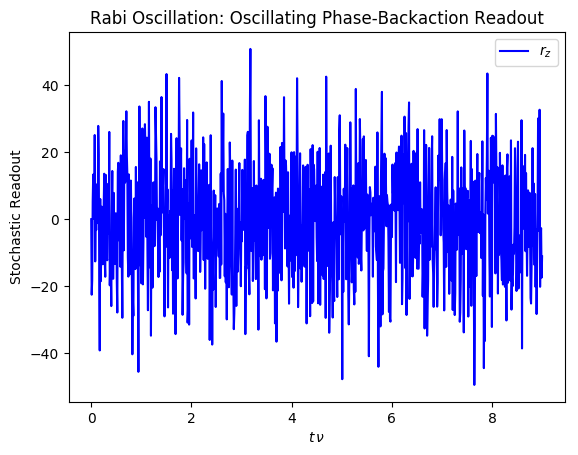

  0.097937 seconds (622.40 k allocations: 31.883 MiB, 9.59% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.095627964 s, Steps per second: 9401.01579491957


In [20]:
sol = ensemble_realization(tmeas=true, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true, ϕ=π/2)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Oscillating Phase-Backaction")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1


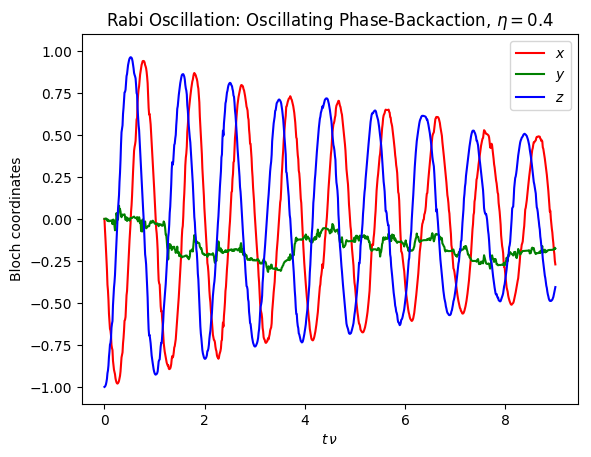

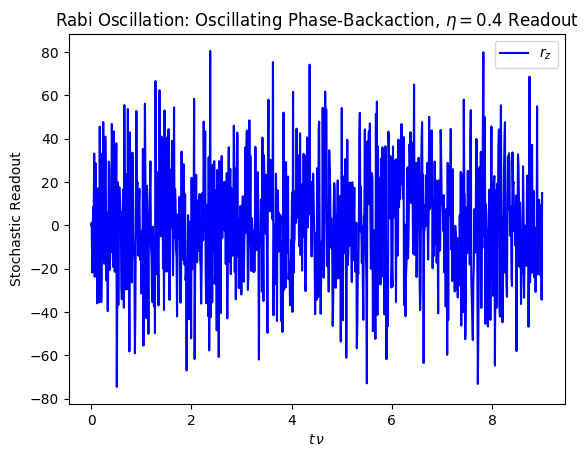

  0.182873 seconds (1.43 M allocations: 74.180 MiB, 5.33% gc time)


INFO: Time elapsed: 0.182080361 s, Steps per second: 4937.380369099774


In [21]:
sol = ensemble_realization(tmeas=true, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true, ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Oscillating Phase-Backaction, $\eta=0.4$")

### Ensembles of trajectories

In [22]:
# Ensemble size, for easy tunability
num = 2000;

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


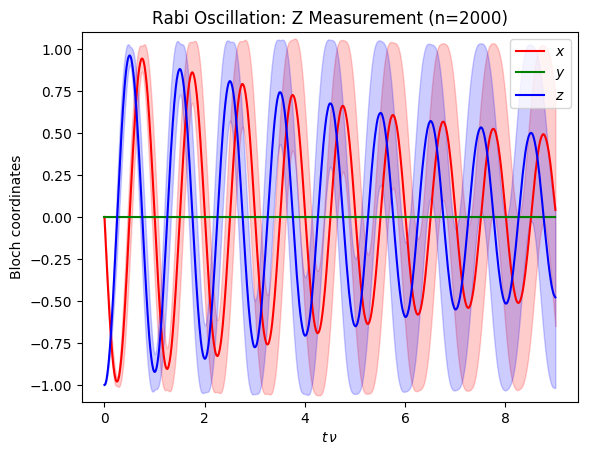

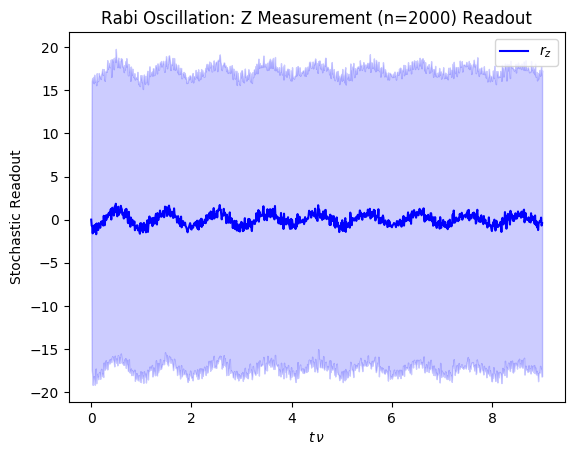

 22.405554 seconds (759.33 k allocations: 144.436 MiB, 0.84% gc time)


INFO: Time elapsed: 22.200009192 s, Steps: 1798000, Steps per second: 80990.95745635671


In [23]:
e = ensemble_realization(n=2, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Z Measurement (n=$num)")

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


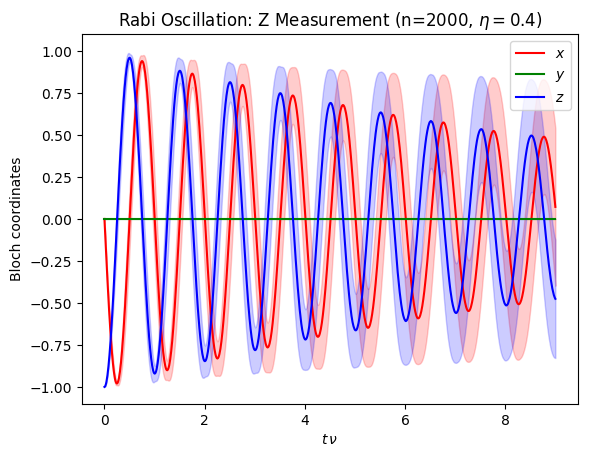

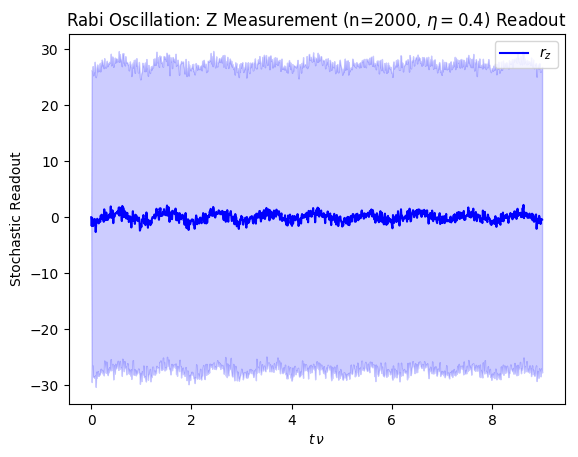

 42.952882 seconds (449.76 k allocations: 130.762 MiB, 0.15% gc time)


INFO: Time elapsed: 42.82938692 s, Steps: 1798000, Steps per second: 41980.52153672995


In [24]:
e = ensemble_realization(n=2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Z Measurement (n=$num, \$\\eta=0.4\$)"))

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


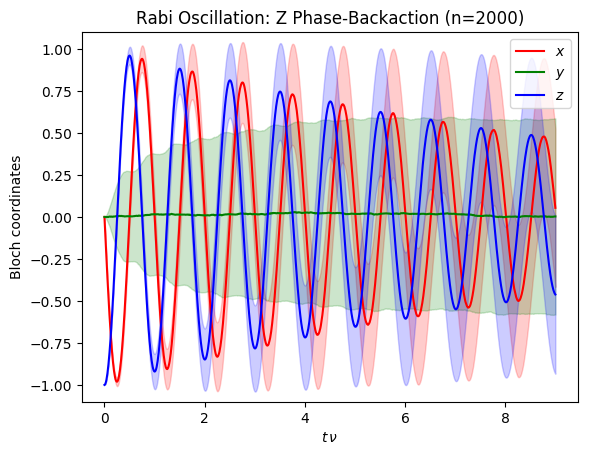

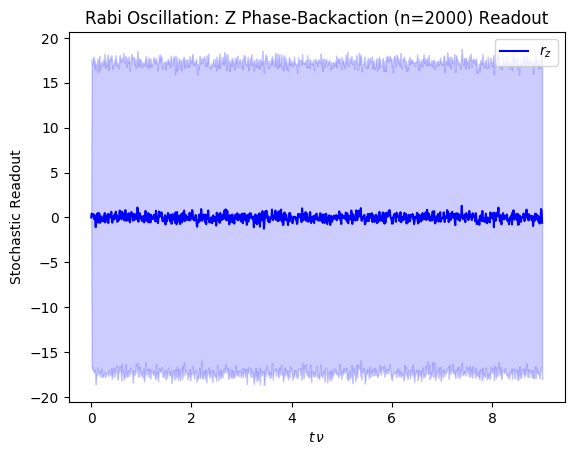

 17.626112 seconds (447.32 k allocations: 134.384 MiB, 0.18% gc time)


INFO: Time elapsed: 17.570767391 s, Steps: 1798000, Steps per second: 102329.05370547228


In [25]:
e = ensemble_realization(n=2, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Z Phase-Backaction (n=$num)")

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


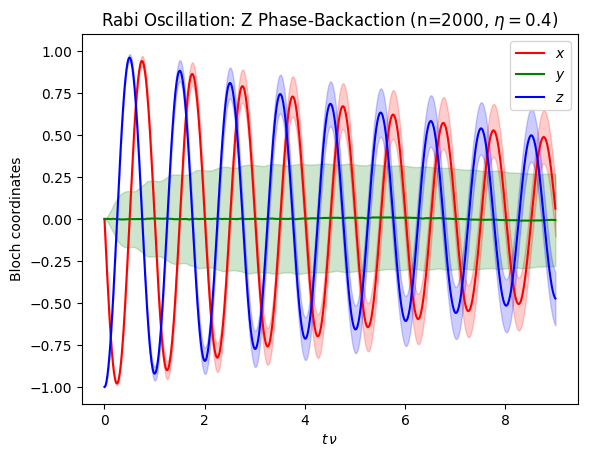

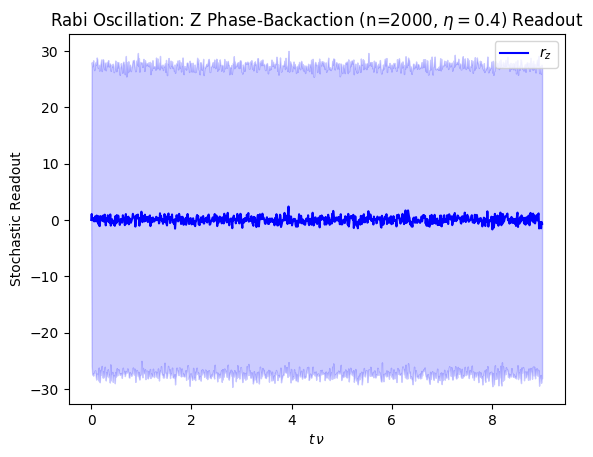

 35.591649 seconds (451.96 k allocations: 134.627 MiB, 0.09% gc time)


INFO: Time elapsed: 35.532432725 s, Steps: 1798000, Steps per second: 50601.6577563224


In [26]:
e = ensemble_realization(n=2, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Z Phase-Backaction (n=$num, \$\\eta=0.4\$)"))

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


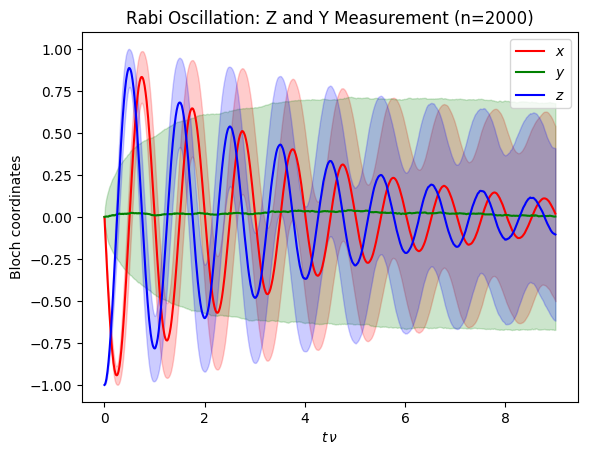

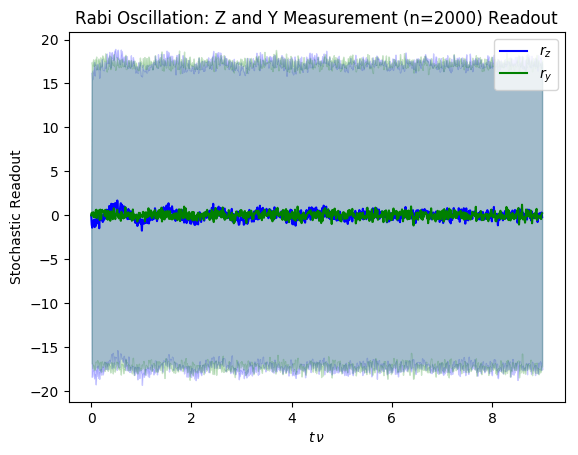

 22.845649 seconds (487.96 k allocations: 160.334 MiB, 0.15% gc time)


INFO: Time elapsed: 22.781726961 s, Steps: 1798000, Steps per second: 78922.90180977031


In [27]:
e = ensemble_realization(n=2, ymeas=true, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Measurement (n=$num)")

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


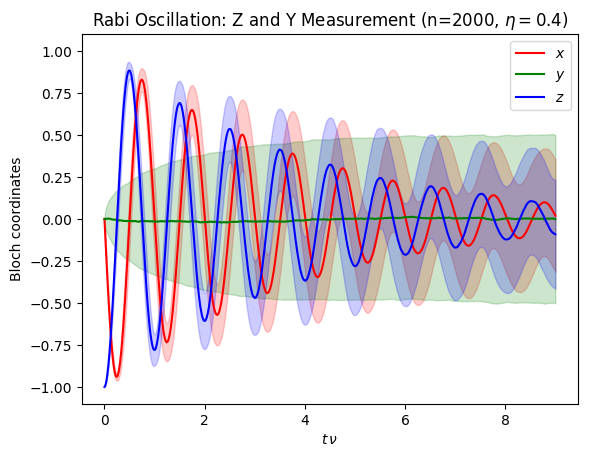

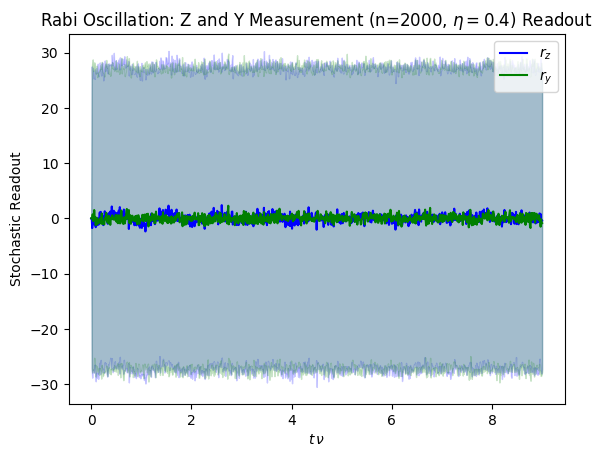

 45.893694 seconds (497.29 k allocations: 161.529 MiB, 0.08% gc time)


INFO: Time elapsed: 45.833536454 s, Steps: 1798000, Steps per second: 39228.91705737196


In [28]:
e = ensemble_realization(n=2, ymeas=true, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title=latexstring("Rabi Oscillation: Z and Y Measurement (n=$num, \$\\eta = 0.4\$)"))

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


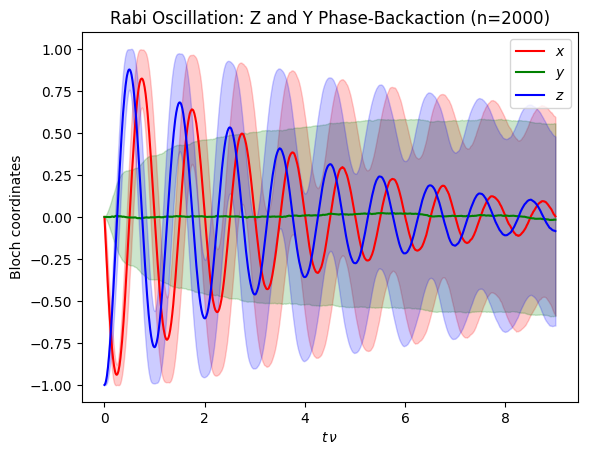

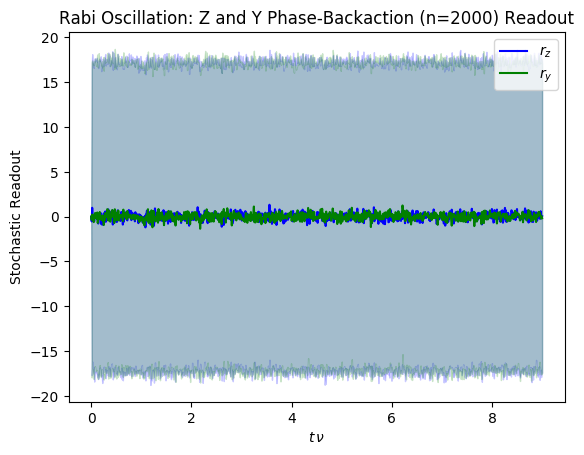

 23.013598 seconds (488.12 k allocations: 160.255 MiB, 0.16% gc time)


INFO: Time elapsed: 22.956663073 s, Steps: 1798000, Steps per second: 78321.48750376007


In [29]:
e = ensemble_realization(n=2, ymeas=true, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Phase-Backaction (n=$num)")

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


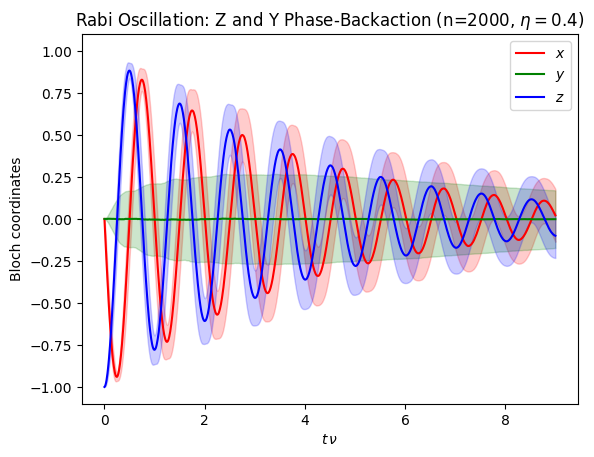

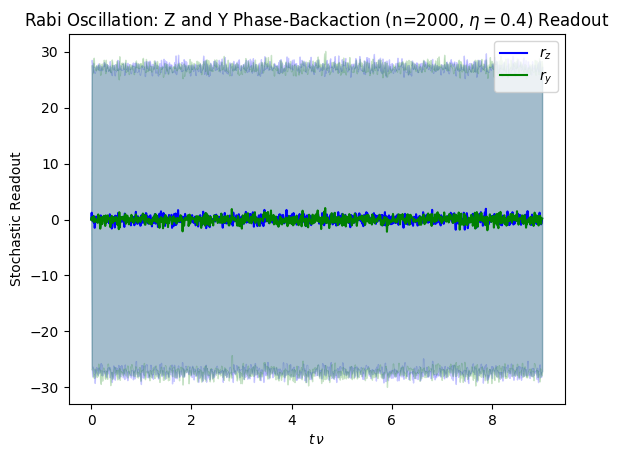

 38.056737 seconds (498.23 k allocations: 164.529 MiB, 0.09% gc time)


INFO: Time elapsed: 38.000570578 s, Steps: 1798000, Steps per second: 47315.07902781154


In [30]:
e = ensemble_realization(n=2, ymeas=true, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title=latexstring("Rabi Oscillation: Z and Y Phase-Backaction (n=$num, \$\\eta = 0.4\$)"))

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


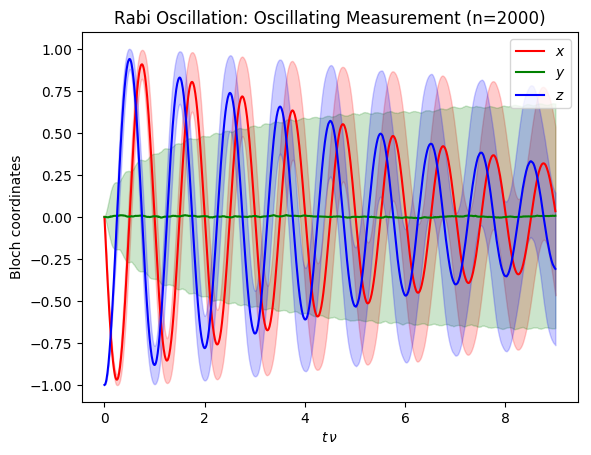

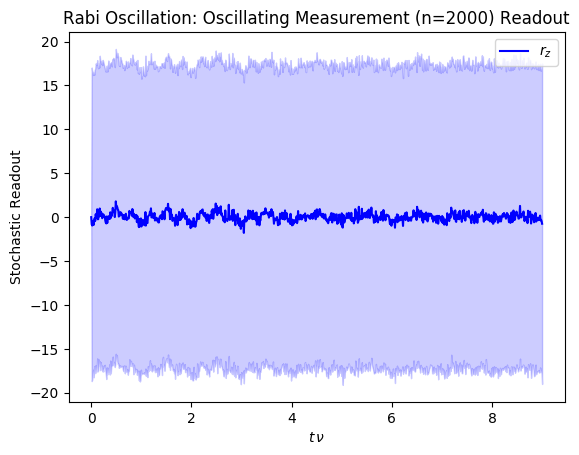

122.445257 seconds (672.49 k allocations: 145.349 MiB, 0.04% gc time)


INFO: Time elapsed: 122.397697861 s, Steps: 1798000, Steps per second: 14689.818774548234


In [31]:
e = ensemble_realization(n=2, tmeas=true, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Oscillating Measurement (n=$num)")

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 239.129471911 s, Steps: 1798000, Steps per second: 7518.939366324472


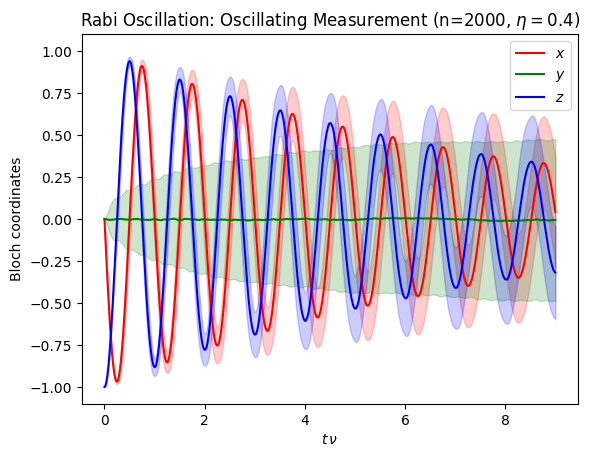

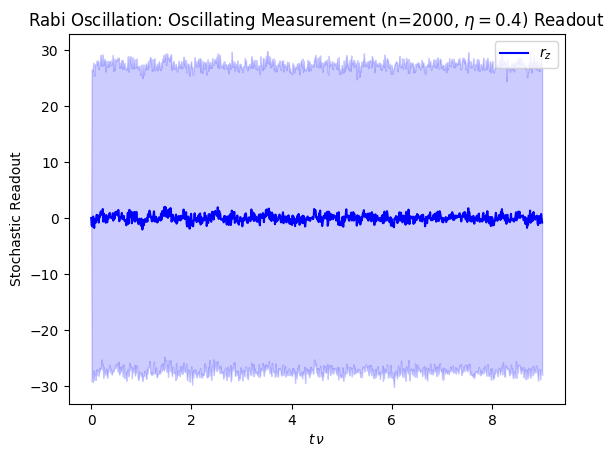

239.200731 seconds (687.64 k allocations: 145.721 MiB, 0.01% gc time)


In [32]:
e = ensemble_realization(n=2, tmeas=true, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Oscillating Measurement (n=$num, \$\\eta = 0.4\$)"))

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


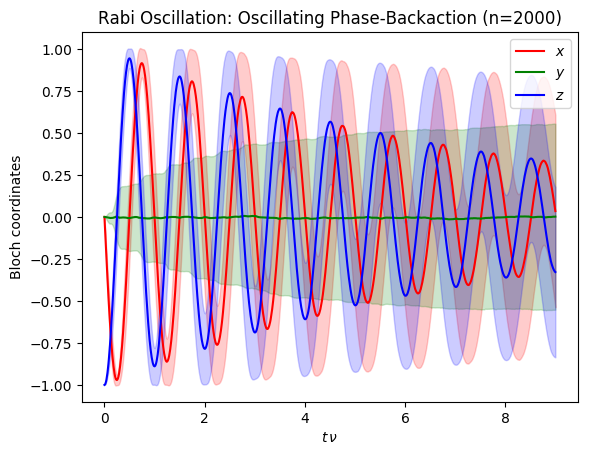

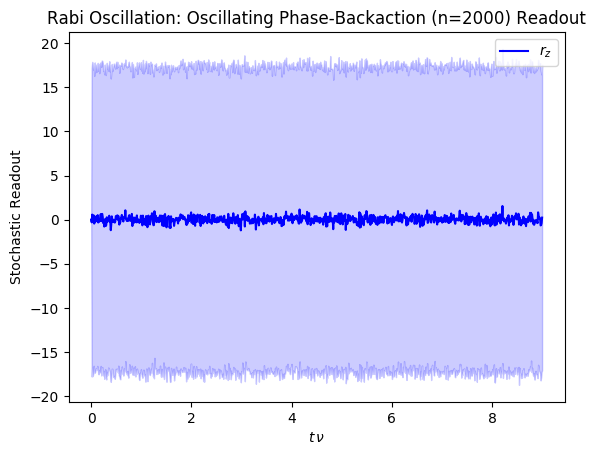

105.587534 seconds (672.11 k allocations: 145.335 MiB, 0.11% gc time)


INFO: Time elapsed: 105.475288402 s, Steps: 1798000, Steps per second: 17046.646918349707


In [33]:
e = ensemble_realization(n=2, tmeas=true, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Oscillating Phase-Backaction (n=$num)")

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


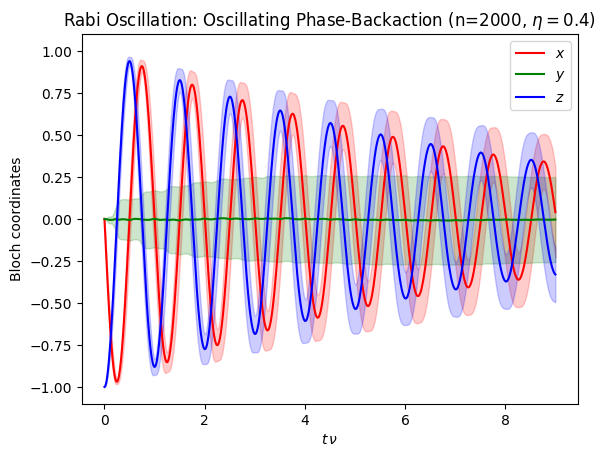

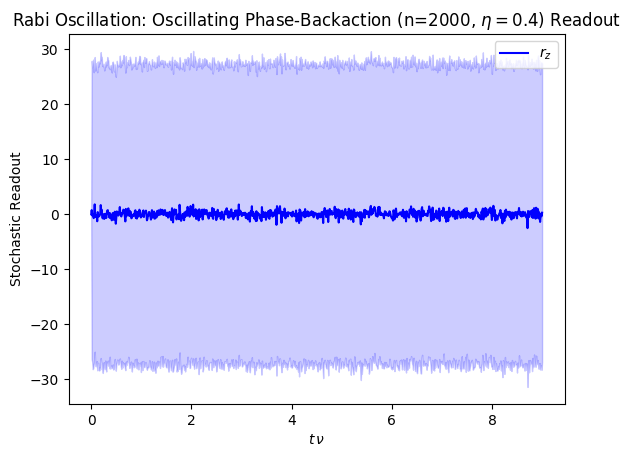

227.696821 seconds (687.31 k allocations: 145.628 MiB, 0.02% gc time)


INFO: Time elapsed: 227.649407212 s, Steps: 1798000, Steps per second: 7898.109738215135


In [34]:
e = ensemble_realization(n=2, tmeas=true, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Oscillating Phase-Backaction (n=$num, \$\\eta = 0.4\$)"))

## Conclusions

The Quantum Bayesian method for computing stochastic evolution works well and is competitive in speed with the direct Lindblad integration. It is both dramatically faster and much more accurate than any of the currently available stochastic integration solvers in the ```DifferentialEquations``` package.

## Version Information

In [35]:
versioninfo()

Julia Version 0.6.0
Commit 9036443 (2017-06-19 13:05 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-6560U CPU @ 2.20GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, skylake)


In [36]:
Pkg.installed("PyPlot")

v"2.3.2"

In [37]:
Pkg.installed("QuantumBayesian")

v"0.2.0+"

In [38]:
Pkg.installed("Interpolations")

v"0.6.2"